# This project aims to use Natural Language Processing (NLP) to categorise product on the basis of reviews given by shoppers. 

## Scope of this notebook:
    1) EDA, data pre-processing
    2) visualization to get some meaningful insights
    3) unsupervised classification on review texts
    4) using Topic Modeling finding topics from user review
    
    
    5) ** enabeling auto labeler from extarcted topics  (Work in progress)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import sklearn
import re
import nltk
stop_words = set(stopwords.words('english'))
from nltk.probability import FreqDist
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
df=pd.read_csv('User_Reviews.csv')
df.head()

,Text
0,I absolutly love this modle. It is soooooooo c...
1,I love this parfum spray. I was very pleased a...
2,"We love this collar! It's sturdy, convenient, ..."
3,The game that made me the most competitive foo...
4,Got this for my boyfriend after smelling it in...


## <span style='color:red'>EDA</span>

In [3]:
# data overview
print ('Rows     : ', df.shape[0])
print ('Columns  : ', df.shape[1])
print ('\nFeatures : ', df.columns.tolist())
print ('\nMissing values :  ', df.isnull().sum().values.sum())
print ('\nUnique values :  \n', df.nunique())

Rows     :  3227
Columns  :  1

Features :  ['Text']

Missing values :   0

Unique values :  
 Text    3220
dtype: int64


In [4]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3227 entries, 0 to 3226
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    3227 non-null   object
dtypes: object(1)
memory usage: 25.3+ KB


Text    0
dtype: int64

In [6]:
# drop the rows having null values for reviews text
df = df.dropna(subset=['Text'])

In [16]:
df['Text'].value_counts()[1:50] # There are some duplicates also present

I didn't know the fragance of this perfume but my girlfriend wanted it. She was so happy with the gift, and I learned it smells really nice.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## <span style='color:green'> Data Visualization</span>

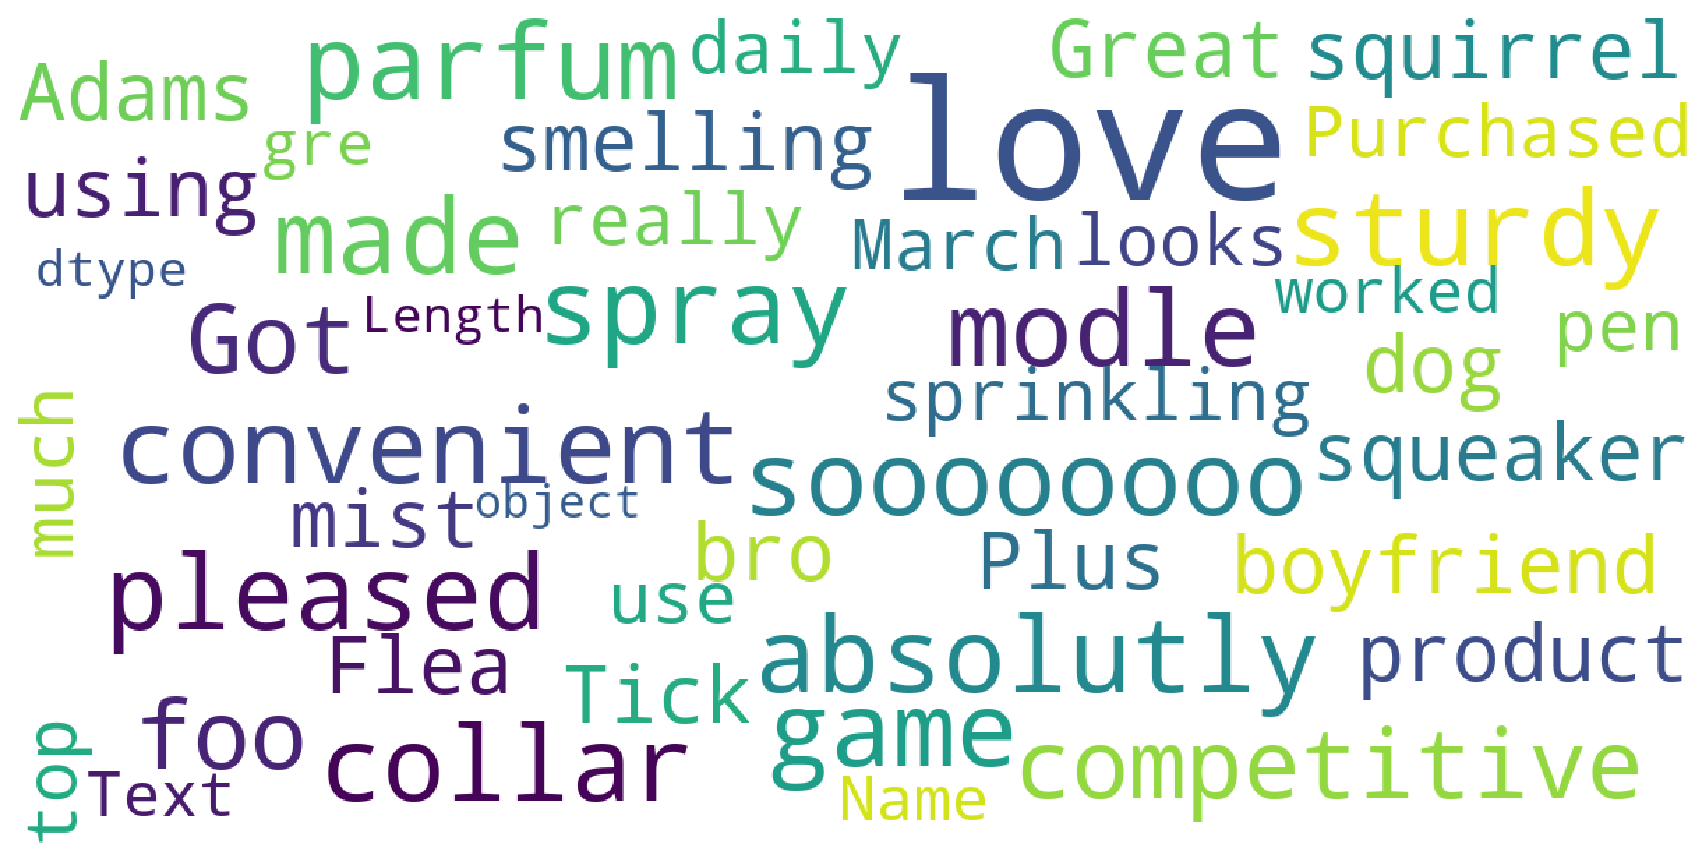

In [19]:
#Visualizing the word, to find the intent of words
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=300,
        max_font_size=40, 
        scale=3,
        random_state=1    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['Text'])

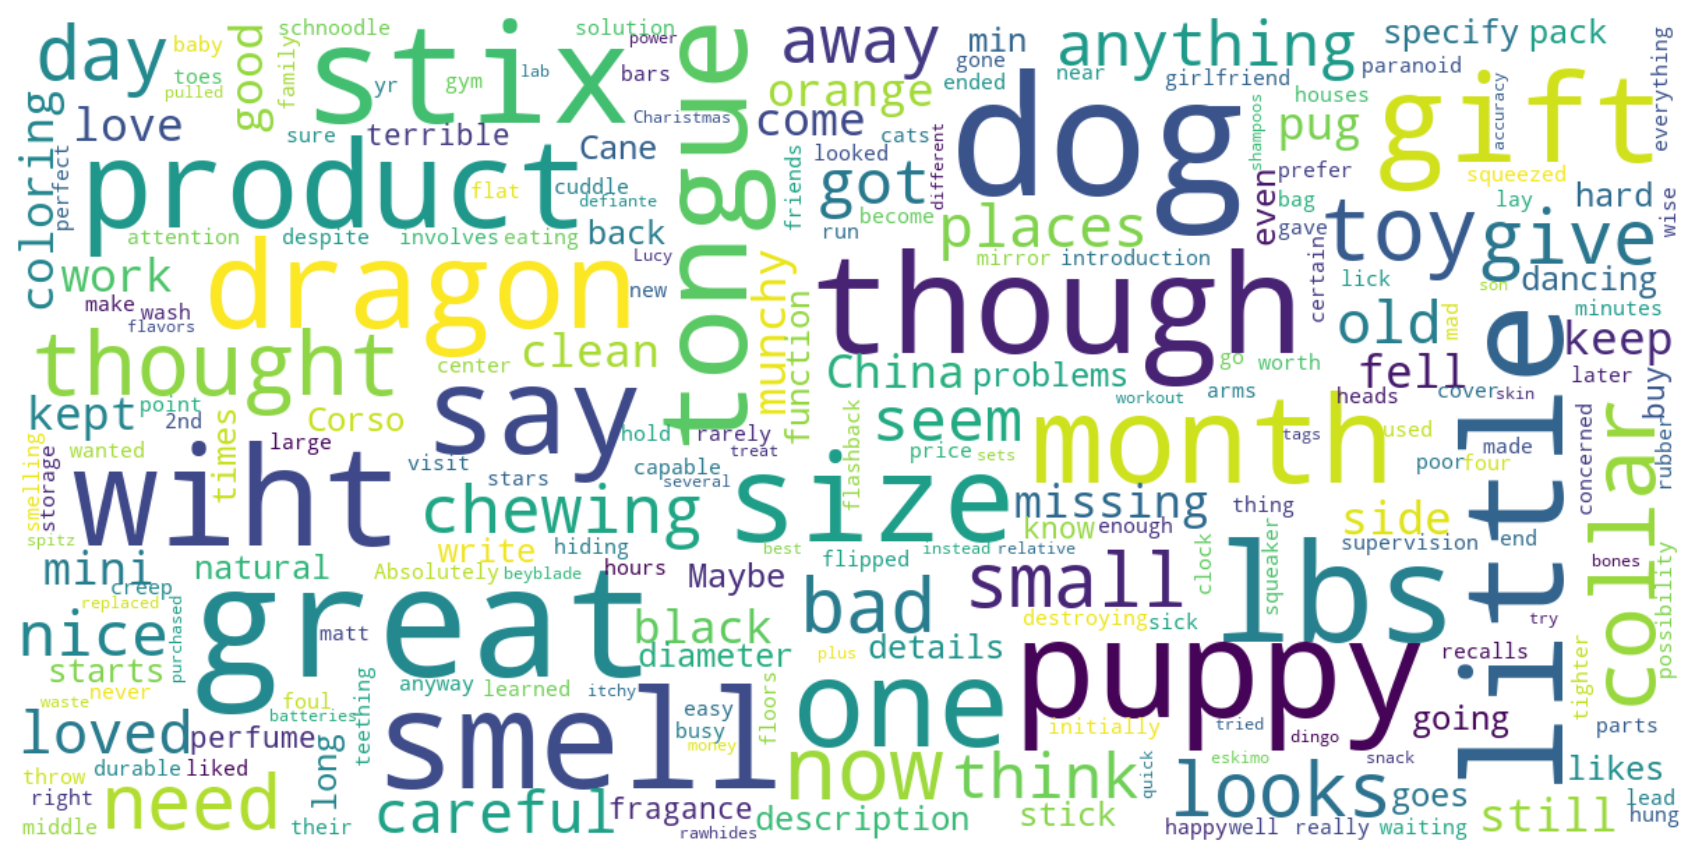

In [20]:
# alternate code, seems to yield different results
wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=300, max_font_size=40, scale=3,
        random_state=1).generate(str(df['Text'].value_counts()))
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

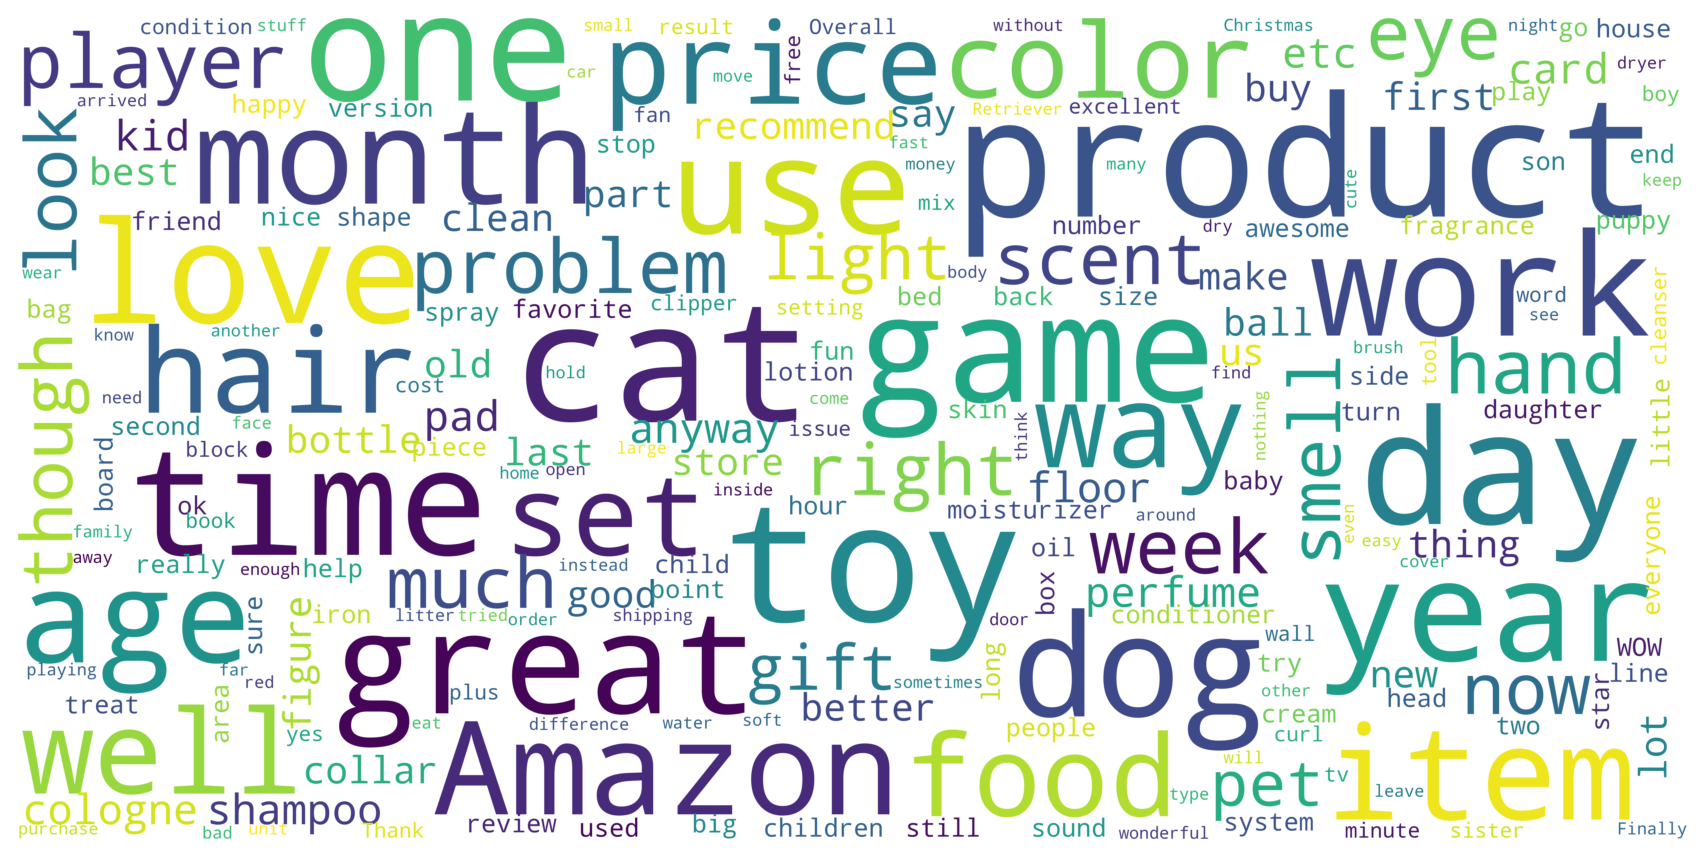

In [21]:
# try to tokenize to individual word (uni-gram) - reviews
split_title = []
listCounts = []
split_title = [x.split(" ") for x in df['Text'].astype(str)]
big_list = []
for x in split_title:
    big_list.extend(x)

listCounts = pd.Series(big_list).value_counts()

wordcloud = WordCloud(background_color='white', max_words=400, max_font_size=40, scale=30,
        random_state=1).generate((listCounts[listCounts > 2]).to_string())
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
len(big_list) 

271377

## <span style='color:blue'> Data Preprocessing</span>

In [25]:
def clean_text(text):
    """
    Summary: turns text input string into list of cleaned word tokens
    
    Arguments:
        text: str of text
    
    Returns:
        lemmatized_words: str, lemmatized words from original text after cleaning
    """
    
    # remove numbers
    clean_text = re.sub(r'[0-9]+', '', text)
    
    # remove punctuation
    clean_text = re.sub(r'[^\w\s]', '', clean_text)
    
    # convert everything to lowercase
    clean_text = clean_text.lower()
    
    # tokenize
    wt = WhitespaceTokenizer()
    words = wt.tokenize(clean_text)
    
    # remove stop words
    cleaned_words = []
    for w in words:
        if w not in stop_words:
            cleaned_words.append(w)
            
    # lemmatize words
    wnl = WordNetLemmatizer()
    wnl_lemmatized_tokens = []
    for token in cleaned_words:
        wnl_lemmatized_tokens.append(wnl.lemmatize(token))
    
    lemmatized_words = ' '.join(wnl_lemmatized_tokens)
    
    return lemmatized_words

In [27]:
df['cleaned_text'] = df['Text'].apply(lambda x: clean_text(x))
df.head()

,Text,cleaned_text
0,I absolutly love this modle. It is soooooooo c...,absolutly love modle soooooooo cool big smarty...
1,I love this parfum spray. I was very pleased a...,love parfum spray pleased price well size bott...
2,"We love this collar! It's sturdy, convenient, ...",love collar sturdy convenient beautiful weve g...
3,The game that made me the most competitive foo...,game made competitive fool worldyou cant start...
4,Got this for my boyfriend after smelling it in...,got boyfriend smelling men fitness love cologn...


In [28]:
clean_text = ' '.join(list(df['cleaned_text'].values))

In [30]:
# tokenize
wt = WhitespaceTokenizer()
clean_tokens = wt.tokenize(clean_text)

freq_dist = FreqDist(clean_tokens)
print(freq_dist)

<FreqDist with 14229 samples and 132392 outcomes>


In [31]:
freq_dist.most_common(500)

[('one', 1366),
 ('product', 1141),
 ('like', 1103),
 ('love', 1057),
 ('toy', 987),
 ('get', 968),
 ('hair', 963),
 ('would', 938),
 ('great', 918),
 ('dog', 903),
 ('game', 854),
 ('time', 844),
 ('cat', 713),
 ('use', 711),
 ('year', 706),
 ('really', 631),
 ('work', 629),
 ('old', 614),
 ('make', 586),
 ('well', 574),
 ('good', 572),
 ('play', 545),
 ('bought', 533),
 ('even', 529),
 ('much', 521),
 ('little', 521),
 ('dont', 514),
 ('also', 499),
 ('day', 465),
 ('first', 464),
 ('used', 441),
 ('got', 425),
 ('month', 419),
 ('still', 400),
 ('two', 394),
 ('using', 380),
 ('im', 369),
 ('go', 368),
 ('put', 368),
 ('thing', 368),
 ('smell', 352),
 ('think', 349),
 ('fun', 349),
 ('buy', 344),
 ('back', 343),
 ('skin', 340),
 ('box', 329),
 ('recommend', 324),
 ('look', 315),
 ('son', 311),
 ('doesnt', 305),
 ('ive', 304),
 ('say', 301),
 ('price', 296),
 ('could', 293),
 ('keep', 293),
 ('long', 292),
 ('around', 292),
 ('way', 284),
 ('best', 282),
 ('take', 282),
 ('better', 2

In [32]:
freq_dist.get('account')

3

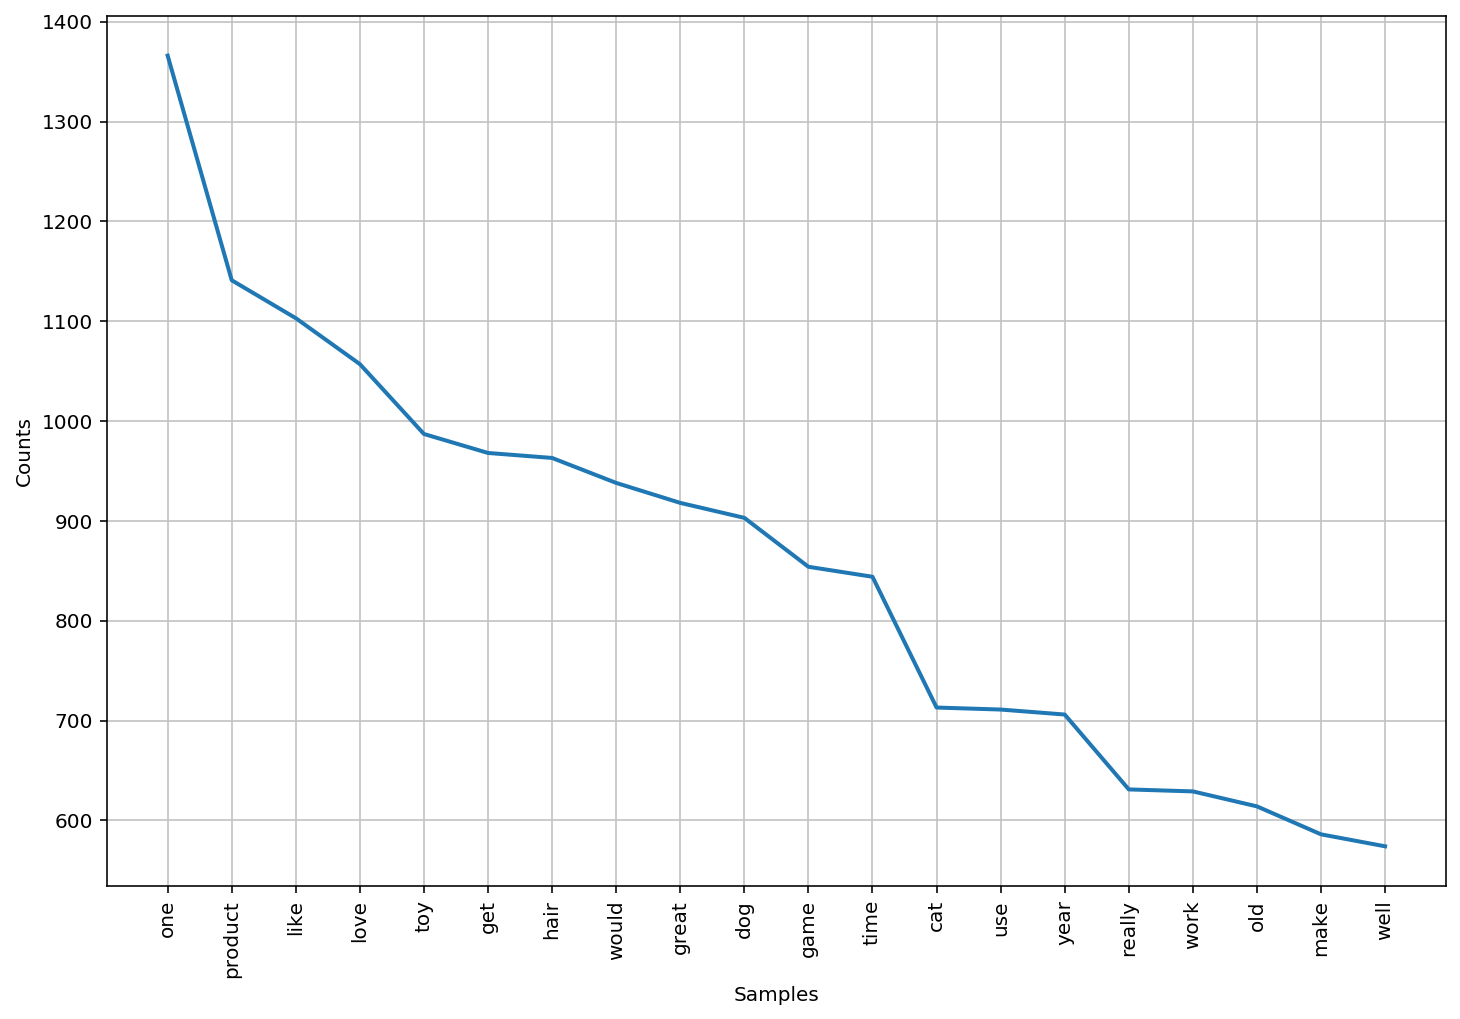

In [33]:
#Checking_word_Freq.
fig, ax = plt.subplots(figsize=(12,8))
freq_dist.plot(20, cumulative=False)
plt.show()

In [34]:
Corpus=df

In [35]:
# Step - a : Remove blank rows if any.
Corpus['cleaned_text'].dropna(inplace=True)
# Step - b : Change all the cleaned_text to lower case. This is required as python interprets 'dog' and 'DOG' differently
Corpus['cleaned_text'] = [entry.lower() for entry in Corpus['cleaned_text']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['cleaned_text']= [word_tokenize(entry) for entry in Corpus['cleaned_text']]
# Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(Corpus['cleaned_text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'cleaned_text_final'
    Corpus.loc[index,'cleaned_text_final'] = str(Final_words)

In [36]:
Corpus

,Text,cleaned_text,cleaned_text_final
0,I absolutly love this modle. It is soooooooo c...,"[absolutly, love, modle, soooooooo, cool, big,...","['absolutly', 'love', 'modle', 'soooooooo', 'c..."
1,I love this parfum spray. I was very pleased a...,"[love, parfum, spray, pleased, price, well, si...","['love', 'parfum', 'spray', 'pleased', 'price'..."
2,"We love this collar! It's sturdy, convenient, ...","[love, collar, sturdy, convenient, beautiful, ...","['love', 'collar', 'sturdy', 'convenient', 'be..."
3,The game that made me the most competitive foo...,"[game, made, competitive, fool, worldyou, cant...","['game', 'make', 'competitive', 'fool', 'world..."
4,Got this for my boyfriend after smelling it in...,"[got, boyfriend, smelling, men, fitness, love,...","['get', 'boyfriend', 'smell', 'men', 'fitness'..."
...,...,...,...
3222,My dog loves the squirrel but the squeaker bro...,"[dog, love, squirrel, squeaker, broke, probabl...","['dog', 'love', 'squirrel', 'squeaker', 'break..."
3223,I have been using Adams Plus Flea & Tick mist ...,"[using, adam, plus, flea, tick, mist, several,...","['use', 'adam', 'plus', 'flea', 'tick', 'mist'..."
3224,"Great product, and sprinkling it on top of her...","[great, product, sprinkling, top, wet, food, e...","['great', 'product', 'sprinkle', 'top', 'wet',..."
3225,I really like this pen because it looks much b...,"[really, like, pen, look, much, better, wire, ...","['really', 'like', 'pen', 'look', 'much', 'goo..."


### I'm going to use Topic Modeling to efficiently analyze big unlabeled text data by grouping/clustering them into topics.

#### Latent Dirichlet Allocation / Analysis (LDA)


This is a probabilistic model used to find clusters assigments for documents.
It uses two probability values to cluster documents:

P(word | topic): the probability that a particular word is associated with a particular topic. This first set of probability is also considered as the Word X Topic matrix.
P(topics | documents): the topics associated with documents. This second set of probability is considered as Topics X Documents matrix.
These probability values are calculated for all words, topics and documents.

In [37]:
sample_df=Corpus

In [38]:
sample_df.sample(5) # randomly show 5 rows

,Text,cleaned_text,cleaned_text_final
2957,"My dog loves it and goes crazy for it! Also, o...","[dog, love, go, crazy, also, dog, visiting, pa...","['dog', 'love', 'go', 'crazy', 'also', 'dog', ..."
1440,The description of this game are somewhat vagu...,"[description, game, somewhat, vague, didnt, kn...","['description', 'game', 'somewhat', 'vague', '..."
1821,Excellent product for the treatment of bruises...,"[excellent, product, treatment, bruise, bruise...","['excellent', 'product', 'treatment', 'bruise'..."
2061,Good product with the exception of the clips t...,"[good, product, exception, clip, hold, top, bo...","['good', 'product', 'exception', 'clip', 'hold..."
290,I bought this after being tired of spending 10...,"[bought, tired, spending, salonand, love, hair...","['bought', 'tired', 'spending', 'salonand', 'l..."


#### max_df: float in range [0.0, 1.0] or int, default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

#### min_df: float in range [0.0, 1.0] or int, default=1
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

Be defining the CountVectorizer object as below, we ignore:

all terms that occur over 95% times in our document corpus. We say in this case that the terms occuring more than this threshold are not significant, most of them are stopwords.

all the terms that occur fewer than three times in the entire corpus.

In [40]:
cv = CountVectorizer(max_df=0.95, min_df=3, stop_words="english")
dtm = cv.fit_transform(sample_df['cleaned_text_final'])

In [41]:
dtm

<3227x3586 sparse matrix of type '<class 'numpy.int64'>'
	with 80523 stored elements in Compressed Sparse Row format>

We can observe that our Document X Term Matrix (dtm) has:

    3227 documents, and.
    3586 distinct words
We can also get all those words using the get_feature_names() function

In [42]:
feature_names = cv.get_feature_names()
len(feature_names) # show the total number of distinct words

3586

Let's have a look at some of the features that have been extracted from the documents.

In [45]:
feature_names[3500:]

['weve',
 'whats',
 'whatsoever',
 'wheat',
 'wheel',
 'whim',
 'whistle',
 'white',
 'wide',
 'wider',
 'wife',
 'wiggle',
 'wiht',
 'wild',
 'willing',
 'win',
 'wind',
 'window',
 'wing',
 'winner',
 'winter',
 'wipe',
 'wire',
 'wise',
 'wish',
 'withstand',
 'woman',
 'wonder',
 'wonderful',
 'wonderfully',
 'wont',
 'wood',
 'wooden',
 'woodsy',
 'word',
 'wore',
 'work',
 'worked',
 'worker',
 'workout',
 'workthe',
 'world',
 'worn',
 'worried',
 'worry',
 'worth',
 'wouldnt',
 'wouldve',
 'wound',
 'wow',
 'wrap',
 'wrestle',
 'wrinkle',
 'wrist',
 'write',
 'wrong',
 'xbox',
 'xmas',
 'ya',
 'yard',
 'yea',
 'yeah',
 'year',
 'yearold',
 'yell',
 'yellow',
 'yes',
 'yesterday',
 'yo',
 'yorkie',
 'youd',
 'youll',
 'young',
 'youre',
 'youve',
 'yr',
 'yuck',
 'yup',
 'zap',
 'zero',
 'zip',
 'zipper',
 'zoids',
 'zone',
 'zoo',
 'zoom']

### LDA

From our DTM matrix, we can now build our LDA to extract topics from the underlined texts. The number of topic to be extracted is a hyperparameter, so we do not know it a a glance. In our case, we will be using 7 topics.
LDA is an iterative algorithm, we will have 30 iterations in our case, but the default value is 10.

In [46]:
# Set the number of topics
NB_TOPICS = 7 

# Creat the model
LDA_model = LatentDirichletAllocation(n_components = NB_TOPICS, max_iter = 30, random_state = 2021)

# Fit the model on the dtm
LDA_model.fit(dtm)

LatentDirichletAllocation(max_iter=30, n_components=7, random_state=2021)

### Show Stored Words.
Let's randomnly have a look at some words of that have been stored.

In [48]:
len(feature_names)

3586

In [49]:
import random 
for index in range(15):
    random_word_ID = random.randint(0, 3586)
    print(cv.get_feature_names()[random_word_ID])

triangle
hesitant
mode
consumer
holiday
felt
volume
irritate
disassemble
pay
stock
thumb
healthier
music
surely


### Top Words Per Topic

In [50]:
len(LDA_model.components_[0])

3586

In [51]:
# Pick a single topic 
a_topic = LDA_model.components_[0]

# Get the indices that would sort this array
a_topic.argsort()

array([3228, 1902, 1160, ..., 2156, 1884, 3284])

Let have a look at the top 10 words for the topic we previously took

In [52]:
top_10_words_indices = a_topic.argsort()[-10:]

for i in top_10_words_indices:
    print(cv.get_feature_names()[i])

make
daughter
month
play
year
son
buy
old
love
toy


<span style='color:blue'>This looks like Child Toy Product</span>

In [54]:
for i, topic in enumerate(LDA_model.components_):
    print("THE TOP {} WORDS FOR TOPIC #{}".format(10, i))
    print([cv.get_feature_names()[index] for index in topic.argsort()[-10:]])
    print("\n")

THE TOP 10 WORDS FOR TOPIC #0
['make', 'daughter', 'month', 'play', 'year', 'son', 'buy', 'old', 'love', 'toy']


THE TOP 10 WORDS FOR TOPIC #1
['use', 'love', 'plastic', 'buy', 'item', 'purchase', 'make', 'great', 'pad', 'ball']


THE TOP 10 WORDS FOR TOPIC #2
['time', 'look', 'scent', 'buy', 'love', 'like', 'smell', 'use', 'product', 'hair']


THE TOP 10 WORDS FOR TOPIC #3
['day', 'make', 'skin', 'try', 'time', 'dog', 'work', 'product', 'use', 'cat']


THE TOP 10 WORDS FOR TOPIC #4
['size', 'make', 'little', 'small', 'treat', 'puppy', 'food', 'love', 'toy', 'dog']


THE TOP 10 WORDS FOR TOPIC #5
['cat', 'bag', 'come', 'scoop', 'like', 'make', 'look', 'figure', 'litter', 'box']


THE TOP 10 WORDS FOR TOPIC #6
['time', 'old', 'kid', 'love', 'great', 'like', 'card', 'fun', 'play', 'game']




Attach Discovered Topic Labels to Original User_Reviews

In [55]:
# Link documents to topics
final_topics = LDA_model.transform(dtm)

# Show the shape of the object 
print(final_topics.shape)

(3227, 7)


In [56]:
final_topics

array([[0.00956569, 0.00955139, 0.0095533 , ..., 0.76855532, 0.18365198,
        0.0095834 ],
       [0.16439827, 0.2407599 , 0.42195572, ..., 0.00717837, 0.00716016,
        0.00715962],
       [0.01795004, 0.01792692, 0.41602978, ..., 0.28005236, 0.01795219,
        0.01790179],
       ...,
       [0.01788668, 0.01792048, 0.01795947, ..., 0.51090156, 0.01786505,
        0.01788706],
       [0.09242862, 0.35916379, 0.00421734, ..., 0.00422064, 0.00422006,
        0.00421379],
       [0.42120887, 0.01102314, 0.5236053 , ..., 0.01102382, 0.01106705,
        0.01101356]])

final_topics contains, for each of our 3227 documents, the probability score of how likely a document belongs to each of the 7 topics. This is a Document X Topics matrix. For example, below is the probability values for the third document.

In [57]:
final_topics[3]

array([0.0071543 , 0.00717021, 0.00715592, 0.00716759, 0.00714864,
       0.00714787, 0.95705546])

In [59]:
final_topics[3].argmax()

6

<span style='color:blue'>This value (3) means that our LDA model thinks that the first document belongs to the 6th topic.</span>

#### Combination with the original data
Let's create a new column called Topic that will correspond to the topic value to which each document belongs to.

In [62]:
sample_df["Topic"] = final_topics.argmax(axis=1)

In [63]:
sample_df.head()

,Text,cleaned_text,cleaned_text_final,Topic
0,I absolutly love this modle. It is soooooooo c...,"[absolutly, love, modle, soooooooo, cool, big,...","['absolutly', 'love', 'modle', 'soooooooo', 'c...",4
1,I love this parfum spray. I was very pleased a...,"[love, parfum, spray, pleased, price, well, si...","['love', 'parfum', 'spray', 'pleased', 'price'...",2
2,"We love this collar! It's sturdy, convenient, ...","[love, collar, sturdy, convenient, beautiful, ...","['love', 'collar', 'sturdy', 'convenient', 'be...",2
3,The game that made me the most competitive foo...,"[game, made, competitive, fool, worldyou, cant...","['game', 'make', 'competitive', 'fool', 'world...",6
4,Got this for my boyfriend after smelling it in...,"[got, boyfriend, smelling, men, fitness, love,...","['get', 'boyfriend', 'smell', 'men', 'fitness'...",2


According to our LDA model:

    the first document belongs to 4th topic.
    the second document belongs to 2nd topic.
    the third document belongs to 2nd topic.

## <span style='color:green'> Some more Data Visualization</span>
We will be using the pyldavis module to visualize the topics associated to our documents.

In [64]:
import pyLDAvis.sklearn

In [66]:
pyLDAvis.enable_notebook() # To enable the visualization on the notebook

In [67]:
panel = pyLDAvis.sklearn.prepare(LDA_model, dtm, cv, mds='tsne') # Create the panel for the visualization
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2     -29.594002  60.112713       1        1  22.995924
3     -45.996586  11.891685       2        1  22.363837
0      20.368856  70.019325       3        1  16.944727
6      53.928768  31.704309       4        1  12.461160
4     -12.437127 -26.423267       5        1  11.612649
1       3.965971  21.797720       6        1   7.419960
5      37.524284 -16.517805       7        1   6.201743, topic_info=       Term        Freq       Total Category  logprob  loglift
1340   game  826.000000  826.000000  Default  30.0000  30.0000
1445   hair  929.000000  929.000000  Default  29.0000  29.0000
946     dog  873.000000  873.000000  Default  28.0000  28.0000
3284    toy  955.000000  955.000000  Default  27.0000  27.0000
2318   play  785.000000  785.000000  Default  26.0000  26.0000
...     ...         ...         ...      ...      ...      ...
3476    way   28.536935  274.937415   Topic7  -5.3764   0.5150
2099   nice   26.768945  199.770295   Topic7  -5.4403   0.7704
3455   want   28.959615  320.387071   Topic7  -5.3617   0.3767
1411  great   30.622041  898.091814   Topic7  -5.3059  -0.5982
1385   good   29.483081  626.482578   Topic7  -5.3438  -0.2760

[519 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         3  0.918645     abc
27        2  0.985388    acne
29        2  0.067541  action
29        5  0.067541  action
29        7  0.855519  action
...     ...       ...     ...
3562      2  0.209421    year
3562      3  0.344153    year
3562      4  0.181596    year
3562      5  0.033683    year
3562      6  0.016109    year

[1046 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 7, 5, 2, 6])

This panel shows the topics represented by circles on the left and their set of words on the right. In this graph, we can see that topic 1 is represented by the words Hair, Skin, Shampoo, Perfume, Scent, Smell, etc. From those words, we can infer that this topic is about something <span style='color:Red'>Toiletries</span>

### Ontologies might be helpful if the relationships you are looking for are general enough (i.e. Hair and Shampoo). But their is a chance a same word appear in different topics or user reviews with different intent or correlation

### <span style='color:green'>Hence we're gooing for manual product naming as per described Topics</span>

    Topic {1} : Toileteries Product
    Topic {2} : Pet Prodcut
    Topic {3} : Toy Product
    Topic {4} : Sports Product
    Topic {5} : Food Proudct
    Topic {6} : House Item Product
    Topic {7} : Exterior Product


In [68]:
sample_df

,Text,cleaned_text,cleaned_text_final,Topic
0,I absolutly love this modle. It is soooooooo c...,"[absolutly, love, modle, soooooooo, cool, big,...","['absolutly', 'love', 'modle', 'soooooooo', 'c...",4
1,I love this parfum spray. I was very pleased a...,"[love, parfum, spray, pleased, price, well, si...","['love', 'parfum', 'spray', 'pleased', 'price'...",2
2,"We love this collar! It's sturdy, convenient, ...","[love, collar, sturdy, convenient, beautiful, ...","['love', 'collar', 'sturdy', 'convenient', 'be...",2
3,The game that made me the most competitive foo...,"[game, made, competitive, fool, worldyou, cant...","['game', 'make', 'competitive', 'fool', 'world...",6
4,Got this for my boyfriend after smelling it in...,"[got, boyfriend, smelling, men, fitness, love,...","['get', 'boyfriend', 'smell', 'men', 'fitness'...",2
...,...,...,...,...
3222,My dog loves the squirrel but the squeaker bro...,"[dog, love, squirrel, squeaker, broke, probabl...","['dog', 'love', 'squirrel', 'squeaker', 'break...",4
3223,I have been using Adams Plus Flea & Tick mist ...,"[using, adam, plus, flea, tick, mist, several,...","['use', 'adam', 'plus', 'flea', 'tick', 'mist'...",3
3224,"Great product, and sprinkling it on top of her...","[great, product, sprinkling, top, wet, food, e...","['great', 'product', 'sprinkle', 'top', 'wet',...",4
3225,I really like this pen because it looks much b...,"[really, like, pen, look, much, better, wire, ...","['really', 'like', 'pen', 'look', 'much', 'goo...",3


In [69]:
sample_df['Topic'].value_counts()

2    882
3    706
0    561
6    419
4    363
1    191
5    105
Name: Topic, dtype: int64

In [81]:
sample_df.to_csv('Topic_Modelling_Result.csv')